In [60]:
%load_ext autoreload
%autoreload 2

from tqdm import trange 
import sys 
sys.path.insert(0, '../src/')

import pandas as pd 
import numpy as np 
from datetime import datetime 
import torch 
from torchsummary import summary 

import plotly.graph_objects as go 
import plotly.express as px 


import proption_model 
import hierachy_encoding 
import utils 
import preprocessing 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sales_train_validation = pd.read_csv('../data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('../data/sales_train_evaluation.csv') 
calender = pd.read_csv('../data/calendar.csv') 
date_to_d = dict(zip(calender.date, calender.d)) 
d_to_date = dict(zip(calender.d, calender.date)) 

## Parent nodes sales 

In [3]:
parent_sales = sales_train_validation[sales_train_validation.columns[6:]].sum(axis=0).values
print(parent_sales.shape)

(1913,)


## Hie EDA 

In [4]:
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [5]:
print(sales_train_evaluation.shape)
print(sales_train_evaluation.columns[:6])

(30490, 1947)
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')


In [6]:
groupby_list = ['state_id','store_id','cat_id','dept_id','item_id']

- Fully encoded hierachy 

In [7]:
hierachy_lookup = sales_train_evaluation.groupby(groupby_list[:]).count()[['id']]
hierachy_lookup

id
state_id store_id cat_id    dept_id     item_id            
CA       CA_1     FOODS     FOODS_1     FOODS_1_001       1
                                        FOODS_1_002       1
                                        FOODS_1_003       1
                                        FOODS_1_004       1
                                        FOODS_1_005       1
...                                                      ..
WI       WI_3     HOUSEHOLD HOUSEHOLD_2 HOUSEHOLD_2_512   1
                                        HOUSEHOLD_2_513   1
                                        HOUSEHOLD_2_514   1
                                        HOUSEHOLD_2_515   1
                                        HOUSEHOLD_2_516   1

[30490 rows x 1 columns]

In [8]:
#hierachy_lookup.loc[('CA','CA_1','FOODS','FOODS_1')].index.to_list()

- Partially encoded hierachy

In [9]:
hierachy_lookup_2 = sales_train_evaluation.groupby(groupby_list[2:]).count()[['id']]
hierachy_lookup_2.head()

id
cat_id dept_id item_id        
FOODS  FOODS_1 FOODS_1_001  10
               FOODS_1_002  10
               FOODS_1_003  10
               FOODS_1_004  10
               FOODS_1_005  10

In [10]:
hierachy_lookup_2

id
cat_id    dept_id     item_id            
FOODS     FOODS_1     FOODS_1_001      10
                      FOODS_1_002      10
                      FOODS_1_003      10
                      FOODS_1_004      10
                      FOODS_1_005      10
...                                    ..
HOUSEHOLD HOUSEHOLD_2 HOUSEHOLD_2_512  10
                      HOUSEHOLD_2_513  10
                      HOUSEHOLD_2_514  10
                      HOUSEHOLD_2_515  10
                      HOUSEHOLD_2_516  10

[3049 rows x 1 columns]

- Category encoded hierachy 

In [11]:
sales_train_evaluation.groupby(groupby_list[2]).count()[['id']]

,id
cat_id,
FOODS,14370
HOBBIES,5650
HOUSEHOLD,10470


- TS encoding generation

In [12]:
hierachy_lookup_2 = hierachy_lookup_2.reset_index()

In [13]:
hierachy_lookup_2.dept_id.value_counts()

FOODS_3        823
HOUSEHOLD_1    532
HOUSEHOLD_2    515
HOBBIES_1      416
FOODS_2        398
FOODS_1        216
HOBBIES_2      149
Name: dept_id, dtype: int64

In [14]:

hierachy_with_encoded_columns = hierachy_encoding.hie_encoder(hierachy_lookup_2, ['cat_id','dept_id','item_id'])

root_to_index = {'root':0}

cat_to_dix = dict(zip(hierachy_with_encoded_columns.cat_id,hierachy_with_encoded_columns.cat_id_))
print(cat_to_dix)


dep_to_dix = dict(zip(hierachy_with_encoded_columns.dept_id,hierachy_with_encoded_columns.dept_id_))
print(dep_to_dix)

item_to_dix = dict(zip(hierachy_with_encoded_columns.item_id,hierachy_with_encoded_columns.item_id_))
#print(item_to_dix)

{'FOODS': 0, 'HOBBIES': 1, 'HOUSEHOLD': 2}
{'FOODS_1': 3, 'FOODS_2': 4, 'FOODS_3': 5, 'HOBBIES_1': 6, 'HOBBIES_2': 7, 'HOUSEHOLD_1': 8, 'HOUSEHOLD_2': 9}


In [15]:
ts_to_index = {}
for dic in [root_to_index, cat_to_dix, dep_to_dix, item_to_dix]:
    ts_to_index.update(dic)
print(len(ts_to_index.items()))

3060


In [16]:
inde_to_ts = dict(zip(ts_to_index.values(), ts_to_index.keys()))
print(len(inde_to_ts.items()))

3059


In [17]:
dep_parent_index = hierachy_encoding.get_parent_index(dep_to_dix, cat_to_dix)
dep_parent_index 

defaultdict(int,
            {'FOODS_1': 0,
             'FOODS_2': 0,
             'FOODS_3': 0,
             'HOBBIES_1': 1,
             'HOBBIES_2': 1,
             'HOUSEHOLD_1': 2,
             'HOUSEHOLD_2': 2})

In [18]:
item_parent_index = hierachy_encoding.get_parent_index(item_to_dix, dep_to_dix)

---- Need to constrcut a grpah here, proceeed to next step first 

In [19]:
hierachy_encoding.get_children_index(cat_to_dix)

defaultdict(list, {'root': [0, 1, 2]})

- Pick a particular familry to construct one training data points 
    - Parent node - 0 
    - Children node - 1, 2, 3 

In [20]:
# collect parent sales 
yp = sales_train_validation.sum(axis=0)[6:].values.reshape(-1,1)# np array 
yp = yp.T 
print(yp.shape)

(1, 1913)


In [21]:
yp

array([[32631, 31749, 23783, ..., 40517, 48962, 49795]], dtype=object)

In [22]:
sales_train_validation.groupby('cat_id').sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,23178,22758,17174,18878,14603,22093,20490,27751,24862,18901,...,28682,32007,34497,26151,24948,23632,23317,26704,31927,32654
HOBBIES,3764,3357,2682,2669,1814,3220,2944,3986,2899,2615,...,3786,4634,4820,3323,3787,3472,3353,4085,4787,4683
HOUSEHOLD,5689,5634,3927,3865,2729,3898,4576,6195,4975,4056,...,9321,11721,12323,8585,8835,8239,8363,9728,12248,12458


In [23]:
# collect the proportinos 
ac = sales_train_validation.groupby('cat_id').sum().values/yp
print(ac.shape)
print(type(ac))

(3, 1913)
<class 'numpy.ndarray'>


In [24]:
print(ac.sum(axis=0).sum())
print(len(ac.sum(axis=0)))

1913.0
1913


In [25]:
ac_df = sales_train_validation.groupby('cat_id').sum()/yp
ac_df = ac_df.rename(columns=d_to_date)
ac_df

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
cat_id,,,,,,,,,,,,,,,,,,,,,
FOODS,0.710306,0.71681,0.722112,0.742877,0.762718,0.756325,0.731524,0.731599,0.75947,0.739129,...,0.686353,0.661821,0.668029,0.687117,0.66404,0.668647,0.665572,0.659081,0.652077,0.655769
HOBBIES,0.11535,0.105736,0.11277,0.105029,0.094746,0.110232,0.105105,0.105083,0.088557,0.10226,...,0.090598,0.095819,0.093338,0.087312,0.100799,0.098237,0.09571,0.100822,0.09777,0.094046
HOUSEHOLD,0.174343,0.177454,0.165118,0.152093,0.142536,0.133443,0.16337,0.163319,0.151973,0.158611,...,0.223049,0.24236,0.238633,0.225571,0.235161,0.233115,0.238718,0.240097,0.250153,0.250186


In [26]:
# visualise the distributions 
ac_df_t = ac_df.T
ac_df_t = ac_df_t.reset_index()
ac_df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      1913 non-null   object
 1   FOODS      1913 non-null   object
 2   HOBBIES    1913 non-null   object
 3   HOUSEHOLD  1913 non-null   object
dtypes: object(4)
memory usage: 59.9+ KB


In [27]:
fig = go.Figure()

for label in list(ac_df_t.columns)[1:]:

    fig.add_trace(go.Scatter(
        name=label,
        mode="lines", x=ac_df_t["index"], y=ac_df_t[label],
        #marker_symbol="star"
    ))

fig.show()

In [28]:
# collect the embedding layer input 
ec = np.array(hierachy_encoding.get_children_index(cat_to_dix)['root']).reshape(-1,1)
ec = np.repeat(ec, 1913, axis=1)
print(ec.shape)
print(type(ec))

(3, 1913)
<class 'numpy.ndarray'>


In [29]:
ec[:,0]

array([0, 1, 2])

In [30]:
if ac.shape[0] == ec.shape[0]: 

    input = np.empty(
        
        (ac.shape[0], ac.shape[1], 3), 
    
    )
    print(input.shape)

    for c in range(input.shape[0]): 
        print(c)
        # print(yp.T.shape)
        # print(ac[c].reshape(-1,1).shape)
        # print(ec[c].reshape(-1,1).shape)
        input[c] = np.concatenate(
            [
                ac[c].reshape(-1,1), 
                yp.T, 
                ## ---- PLACE HOLDER FOR COVARIATES X ---- ## 
                ## ---- PLACE HOLDER FOR COVARIATES X ---- ## 
                ec[c].reshape(-1,1),
            ], 
            axis = 1 
        )
        print(input[c].shape)    
else: 
    raise "size of children in embedding does not agree with size of the children in proportions"

(3, 1913, 3)
0
(1913, 3)
1
(1913, 3)
2
(1913, 3)


In [31]:
print(input.shape)

(3, 1913, 3)


In [32]:
## time batching 
# dimension about the dataset
print('------- Time batched input --------')
History = 28 
Forward = 7

number_observations = input.shape[1] - (History + Forward) + 1

input_time_batched = np.empty(
    (number_observations,input.shape[0], History + Forward, input.shape[-1])
)

for i in range(number_observations):

    input_time_batched[i] = np.array(input[:, i:i + History + Forward, :])

print(input_time_batched.shape)
# print(input_time_batched[0][0])

print("-------- X, y split ------------")
input_array = np.empty((
    number_observations,
    input.shape[0],
    History,
    input.shape[-1])
)

target_array = np.empty((
    number_observations,
    input.shape[0],
    Forward,
    1)
)

# print(input_tensor.shape)
# print(target_tensor.shape)

for i in range(input_time_batched.shape[0]):

    input_array[i] = input_time_batched[i, :, :History, :]

    #print(input_array[i,0,-1,0])

    target_2d = input_time_batched[i, :, History:, 0]
    
    target_array[i] = target_2d.reshape(
        target_2d.shape[0], target_2d.shape[1], 1
    )

    #print(target_array[i,0,0,0])
    #print()

print(f"X input shape is {input_array.shape}")
print(f"y input shape is {target_array.shape}")


------- Time batched input --------
(1879, 3, 35, 3)
-------- X, y split ------------
X input shape is (1879, 3, 28, 3)
y input shape is (1879, 3, 7, 1)


- blue box X shape (1893, 2, 14, 3)
- green box X shape (1893, 2, 14, 3)
- y target is the proportal of ever single child 


In [33]:
#input_array[1,0,:,:]

In [34]:
target_array[0,0,:,:]

array([[0.66554099],
       [0.71968509],
       [0.70932203],
       [0.72437915],
       [0.73564365],
       [0.73448349],
       [0.74291532]])

In [35]:
target_array[1,0,:,:]

array([[0.71968509],
       [0.70932203],
       [0.72437915],
       [0.73564365],
       [0.73448349],
       [0.74291532],
       [0.73943978]])

In [36]:
input_array[0,:,0,:]

array([[7.10306151e-01, 3.26310000e+04, 0.00000000e+00],
       [1.15350434e-01, 3.26310000e+04, 1.00000000e+00],
       [1.74343416e-01, 3.26310000e+04, 2.00000000e+00]])

In [37]:
train_input_array, train_target_array = preprocessing.pre_processing_main(
    sales_train_validation, 
    cat_to_dix,
    History,
    Forward,
)

(3, 1913, 3)
0
(1913, 3)
1
(1913, 3)
2
(1913, 3)
-------- X, y split ------------
X input shape is (1879, 3, 28, 3)
y input shape is (1879, 3, 7, 1)


## Vlidation set  

In [38]:
val_input_array, val_target_array = preprocessing.pre_processing_main(
    sales_train_evaluation, 
    cat_to_dix,
    History,
    Forward,
)

(3, 1941, 3)
0
(1941, 3)
1
(1941, 3)
2
(1941, 3)
-------- X, y split ------------
X input shape is (1907, 3, 28, 3)
y input shape is (1907, 3, 7, 1)


In [39]:
#val_input_array[0]

## Training 

### 1. Define the model object 

In [86]:
### convert np array into torch array 
input_tensor = torch.tensor(train_input_array).float()
target_tensor = torch.tensor(train_target_array).float()

val_input_tensor = torch.tensor(val_input_array).float()[-1]
val_targer_tensor = torch.tensor(val_target_array).float()[-1]

print('The shape of the training tensors is')
print(input_tensor.shape)
print(target_tensor.shape)

print('The shape of the entire validation tensors is')
print(val_input_tensor.shape)
print(val_targer_tensor.shape)

###---------- dimension on the model hypter-parameters from the paper ------------ ######
no_child = 3060 
num_hts_embedd = no_child
hts_embedd_dim = 8
covariate_dim = 0

lstm_input_dim = 2 + covariate_dim + hts_embedd_dim
lstm_hidden_dim = 48
lstm_num_layer = 1
lstm_output_dim = 64

mha_embedd_dim = lstm_output_dim
num_head = 4
num_attention_layer = 1
mha_output_dim = mha_embedd_dim
residual_output_dim = mha_output_dim
model_ouput_dim = 1

# define the model object
p_model = proption_model.proportion_model(
    Forward,
    num_hts_embedd,
    hts_embedd_dim,  # ts embedding hyper pars
    lstm_input_dim,
    lstm_hidden_dim,
    lstm_num_layer,
    lstm_output_dim,  # lstm hyper pars
    mha_embedd_dim,
    num_head,
    num_attention_layer,  # mha hyper pars
    mha_output_dim,
    residual_output_dim,  # skip connection hyper pars
    model_ouput_dim,  # output later hyper pars
    mha_activation = torch.nn.LeakyReLU()
)

###---------- trainign parameters from the paper ------------ ######
n_epochs = 50
target_len = Forward
batch_size = 4
l_r = 0.00079

The shape of the training tensors is
torch.Size([1879, 3, 28, 3])
torch.Size([1879, 3, 7, 1])
The shape of the entire validation tensors is
torch.Size([3, 28, 3])
torch.Size([3, 7, 1])


- Insepect the model

In [87]:
#summary(p_model, input_size=(3, 28, 3))

### Adam Opts

Trainign starting from iteration 0, batch 0
There are 470 batches per iteration


  0%|          | 0/50 [00:00<?, ?it/s]

Trainign for Iteration: 0 starts
Training for Iteration: 0 Batch 0 starts
Training for Iteration: 0 Batch 1 starts
Training for Iteration: 0 Batch 2 starts
Training for Iteration: 0 Batch 3 starts
Training for Iteration: 0 Batch 4 starts
Training for Iteration: 0 Batch 5 starts
Training for Iteration: 0 Batch 6 starts
Training for Iteration: 0 Batch 7 starts
Training for Iteration: 0 Batch 8 starts
Training for Iteration: 0 Batch 9 starts
Training for Iteration: 0 Batch 10 starts
Training for Iteration: 0 Batch 11 starts
Training for Iteration: 0 Batch 12 starts
Training for Iteration: 0 Batch 13 starts
Training for Iteration: 0 Batch 14 starts
Training for Iteration: 0 Batch 15 starts
Training for Iteration: 0 Batch 16 starts
Training for Iteration: 0 Batch 17 starts
Training for Iteration: 0 Batch 18 starts
Training for Iteration: 0 Batch 19 starts
Training for Iteration: 0 Batch 20 starts


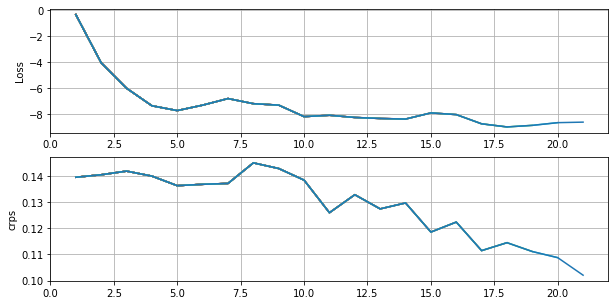

Training for Iteration: 0 Batch 21 starts
Training for Iteration: 0 Batch 22 starts
Training for Iteration: 0 Batch 23 starts
Training for Iteration: 0 Batch 24 starts
Training for Iteration: 0 Batch 25 starts
Training for Iteration: 0 Batch 26 starts
Training for Iteration: 0 Batch 27 starts
Training for Iteration: 0 Batch 28 starts
Training for Iteration: 0 Batch 29 starts
Training for Iteration: 0 Batch 30 starts
Training for Iteration: 0 Batch 31 starts
Training for Iteration: 0 Batch 32 starts
Training for Iteration: 0 Batch 33 starts
Training for Iteration: 0 Batch 34 starts
Training for Iteration: 0 Batch 35 starts
Training for Iteration: 0 Batch 36 starts
Training for Iteration: 0 Batch 37 starts
Training for Iteration: 0 Batch 38 starts
Training for Iteration: 0 Batch 39 starts
Training for Iteration: 0 Batch 40 starts


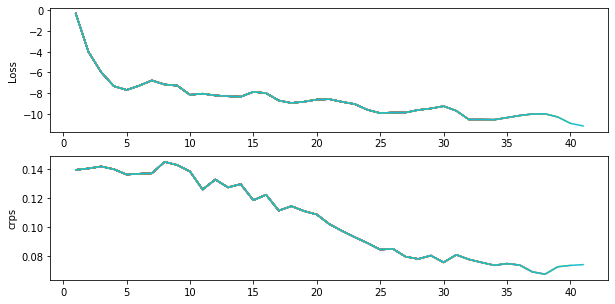

Training for Iteration: 0 Batch 41 starts
Training for Iteration: 0 Batch 42 starts
Training for Iteration: 0 Batch 43 starts
Training for Iteration: 0 Batch 44 starts
Training for Iteration: 0 Batch 45 starts
Training for Iteration: 0 Batch 46 starts
Training for Iteration: 0 Batch 47 starts
Training for Iteration: 0 Batch 48 starts
Training for Iteration: 0 Batch 49 starts
Training for Iteration: 0 Batch 50 starts
Training for Iteration: 0 Batch 51 starts
Training for Iteration: 0 Batch 52 starts
Training for Iteration: 0 Batch 53 starts
Training for Iteration: 0 Batch 54 starts
Training for Iteration: 0 Batch 55 starts
Training for Iteration: 0 Batch 56 starts
Training for Iteration: 0 Batch 57 starts
Training for Iteration: 0 Batch 58 starts
Training for Iteration: 0 Batch 59 starts
Training for Iteration: 0 Batch 60 starts


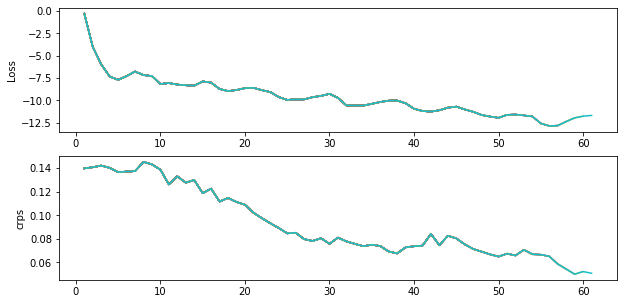

Training for Iteration: 0 Batch 61 starts
Training for Iteration: 0 Batch 62 starts
Training for Iteration: 0 Batch 63 starts
Training for Iteration: 0 Batch 64 starts
Training for Iteration: 0 Batch 65 starts
Training for Iteration: 0 Batch 66 starts
Training for Iteration: 0 Batch 67 starts
Training for Iteration: 0 Batch 68 starts
Training for Iteration: 0 Batch 69 starts
Training for Iteration: 0 Batch 70 starts


  0%|          | 0/50 [00:32<?, ?it/s]


KeyboardInterrupt: 

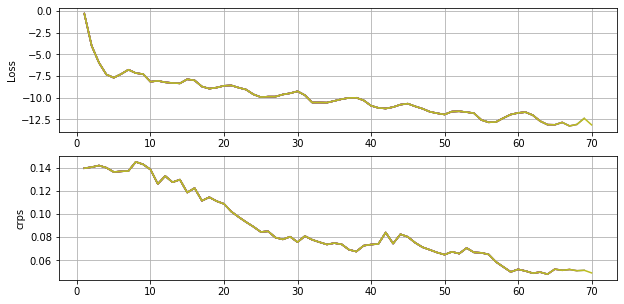

In [88]:
## Training without gradient clipping 
model, iter_losses = proption_model.train_model(
    p_model, 
    input_tensor, 
    target_tensor, 
    n_epochs, 
    target_len, 
    batch_size, 
    l_r,
    clip = False,
    tracing = True, 
    val_input_tensor=val_input_tensor,
    val_target_tensor=val_targer_tensor,
    epsilon=1e-04,
    threshold=0.99,
    )


- the maximum epsilon that you can add to the system universally is 14-07
- research into applying layer normalisation after the exp() link function 

In [91]:
#torch.load('model.pt')
# TODO : eval data set 
# TODO : eval logic 
# TODO : extend the training to other families 
# TODO : experiment with the order of the trainings

- ## PROD CODE FOLLOWING 

In [70]:
hl_prod = sales_train_validation.groupby(groupby_list[2:]).count()[['id']].reset_index()
hl_prod.head()

,cat_id,dept_id,item_id,id
0,FOODS,FOODS_1,FOODS_1_001,10
1,FOODS,FOODS_1,FOODS_1_002,10
2,FOODS,FOODS_1,FOODS_1_003,10
3,FOODS,FOODS_1,FOODS_1_004,10
4,FOODS,FOODS_1,FOODS_1_005,10


In [75]:
df_left = hl_prod
df_right = sales_train_validation.groupby('item_id').sum()
df = df_left.merge(df_right, left_on='item_id', right_index=True, how='inner').drop(columns=['id'])
df.rename(columns=d_to_date, inplace=True)

In [76]:
df 

,cat_id,dept_id,item_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,FOODS,FOODS_1,FOODS_1_001,6,6,4,6,7,18,10,...,4,4,30,7,5,3,6,2,16,6
1,FOODS,FOODS_1,FOODS_1_002,4,5,7,4,3,4,1,...,5,9,4,1,3,5,5,3,3,1
2,FOODS,FOODS_1,FOODS_1_003,14,8,3,6,3,8,13,...,7,3,5,6,3,4,4,3,11,5
3,FOODS,FOODS_1,FOODS_1_004,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FOODS,FOODS_1,FOODS_1_005,34,32,13,20,10,21,18,...,16,14,14,18,18,27,12,15,38,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_512,5,4,1,3,2,4,2,...,6,7,9,13,12,2,8,6,10,5
3045,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_513,0,0,0,0,0,0,0,...,9,3,3,3,2,4,6,7,4,11
3046,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_514,4,8,2,1,1,2,3,...,1,2,2,0,1,0,0,2,2,2
3047,HOUSEHOLD,HOUSEHOLD_2,HOUSEHOLD_2_515,0,0,0,0,0,0,0,...,1,3,2,0,0,1,1,1,5,1


## Time related covariates: 

- Wehther it is weekend/not, we observed sales are high overweekend across three categories 

In [4]:
date = [d_to_date[d] for d in sales_train_validation.columns[6:]]

In [5]:
print(f'The statrting date is {date[0]}')
print(f'The statrting date is {date[-1]}')

The statrting date is 2011-01-29
The statrting date is 2016-04-24


In [6]:
d = datetime.strptime(date[2], '%Y-%m-%d')
if d.weekday() > 4:
    print ('Given date is weekend.')
else:
    print ('Given data is weekday.')

Given data is weekday.


In [7]:
d.weekday()

0

In [8]:
weekend_binary = [1 if (datetime.strptime(d, '%Y-%m-%d')).weekday() > 4 else 0 for d in date]
print(len(weekend_binary))

1913


## Proportions

In [9]:
stv = sales_train_validation[sales_train_validation.columns[6:]]
stv = stv.T
print(stv.shape)

(1913, 30490)


In [10]:
len(stv.sum(axis=1).values)

1913

## Time series embeddings 

In [13]:
hie_index = torch.arange(stv.shape[1])

hie_index_2d = hie_index.expand(stv.shape[0], stv.shape[1])

hie_index_3d = hie_index_2d.reshape(
    hie_index_2d.shape[0], hie_index_2d.shape[-1], 1
)

print(hie_index_3d.shape)


torch.Size([1913, 30490, 1])


In [14]:
stv_proportions = np.divide(stv.values, stv.sum(axis=1).values.reshape(-1,1))
print(stv_proportions.sum(axis=1).sum())

stv_proportions_3d = stv_proportions.reshape(stv_proportions.shape[0], stv_proportions.shape[1], 1)
print(stv_proportions_3d.shape)

proportions_tensor = torch.tensor(stv_proportions_3d)
print(proportions_tensor.shape)

1913.0
(1913, 30490, 1)
torch.Size([1913, 30490, 1])


In [15]:

weekend_binary_tensor = torch.tensor(weekend_binary).unsqueeze_(-1).unsqueeze_(-1)
weekend_binary_tensor = weekend_binary_tensor.expand(stv_proportions.shape[0], stv_proportions.shape[1], weekend_binary_tensor.shape[-1])
print(weekend_binary_tensor.shape)
print(weekend_binary_tensor[1,0])
print(weekend_binary_tensor[2,0])


torch.Size([1913, 30490, 1])
tensor([1])
tensor([0])


In [16]:
parent_sales_tensor = torch.tensor(parent_sales).unsqueeze_(-1).unsqueeze_(-1)
parent_sales_tensor = parent_sales_tensor.expand(stv_proportions.shape[0], stv_proportions.shape[1], parent_sales_tensor.shape[-1])
print(parent_sales_tensor.shape)

torch.Size([1913, 30490, 1])


In [17]:
data_3d = torch.cat((proportions_tensor, parent_sales_tensor,weekend_binary_tensor, hie_index_3d), -1)
data_3d = data_3d.double()
print(data_3d.shape)

torch.Size([1913, 30490, 4])


In [18]:
# dimension about the dataset
no_child = proportions_tensor.shape[1]
History = 28
Forward = 28

number_observations = data_3d.shape[0] - (History + Forward) + 1

data_3d_time_batched = torch.empty(
    number_observations, History + Forward, data_3d.shape[1], data_3d.shape[2]
)

for i in range(number_observations):

    data_3d_time_batched[i, :, :, :] = data_3d[i : i + History + Forward, :, :]

print(data_3d_time_batched.shape)
print(data_3d_time_batched[-1,:,:,:].shape)


#if torch.equal(data_3d_time_batched[-1, -1, :, :].double(), data_3d[-1, :, :].double()):

print("data correctly processed to generate time-bacted tensor")

input_tensor = torch.empty(
    number_observations,
    History,
    data_3d_time_batched.shape[-2],
    data_3d_time_batched.shape[-1],
)

## We first use the recursive predicitng mechanism in LSTM, in the future we release more blocks that adapt to teacher-forcing/mixed training
target_tensor = torch.empty(
    number_observations,
    Forward,
    data_3d_time_batched.shape[-2],
    1
    # data_3d_time_batched.shape[-1]
)

print(input_tensor.shape)
print(target_tensor.shape)

print("Entering the training pipeline")

for i in range(data_3d_time_batched.shape[0]):

    input_tensor[i] = data_3d_time_batched[i, :History, :, :]
    target_2d = data_3d_time_batched[i, History:, :, 0]
    target_tensor[i] = target_2d.reshape(
        target_2d.shape[0], target_2d.shape[1], 1
    )

    # print(input_tensor.shape)
    # print(target_tensor.shape)

print(input_tensor.shape)
print(target_tensor.shape)
    # print(target_tensor[-1,0,:,:].sum())

torch.Size([1858, 56, 30490, 4])
torch.Size([56, 30490, 4])
data correctly processed to generate time-bacted tensor
torch.Size([1858, 28, 30490, 4])
torch.Size([1858, 28, 30490, 1])
Entering the training pipeline
torch.Size([1858, 28, 30490, 4])
torch.Size([1858, 28, 30490, 1])
